# Introduction

In this project, we will use **Independent Component Analysis (ICA)** to separate mixed audio signals into their original independent components. ICA is a computational method used to separate a multivariate signal into additive, independent sources. This is particularly useful in situations where multiple sources are recorded together (such as different voices in an audio recording), and we wish to separate them into distinct signals.

#### Key Objectives:
1. **Load Mixed Audio Files**: We will start by loading the mixed audio signals from `.wav` files using the `wave` library.
2. **Extract and Visualize Signals**: After loading the signals, we will extract and visualize them to better understand the structure of the mixed audio data.
3. **Apply ICA**: Using the `FastICA` algorithm from the `sklearn.decomposition` module, we will separate the mixed signals into independent components.
4. **Convert Separated Signals**: After separating the signals, we will convert them back into `.wav` files and listen to the separated audio.
5. **Visualize Results**: Finally, we will plot the independent components and play the separated audio files to evaluate the effectiveness of ICA.

#### Libraries Used:
- **NumPy** for numerical operations and data handling.
- **Wave** and **SciPy** for reading and writing WAV audio files.
- **Matplotlib** for plotting and visualizing the waveforms.
- **FastICA** from the `sklearn.decomposition` module for separating the signals using ICA.
- **IPython.display.Audio** to play audio files directly within the Jupyter notebook.

By the end of this notebook, you will have a clear understanding of how to apply ICA to separate mixed audio signals, visualize the components, and reconstruct the separated signals for playback.

### 1. Import necessary libraries

In [1]:
import numpy as np
import wave
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy.io import wavfile
from IPython.display import Audio

### 2. Load the mixed audio files and extract parameters

Here we load the mixed audio files using the wave library, which allows us to open .wav files for reading. We also extract parameters from one of the files to understand its properties such as the number of channels, sample width, and frame rate. Finally, we calculate the length of the audio in seconds by dividing the total number of frames by the frame rate.

In [3]:
mix_wave_1 = wave.open("mix_1.wav", 'r')
mix_wave_2 = wave.open("mix_2.wav", 'r')
mix_wave_3 = wave.open("mix_3.wav", 'r')

# Extract and display the parameters of the first audio file
mix_wave_1_params = mix_wave_1.getparams()
print("Audio Parameters (mix_wave_1):", mix_wave_1_params)

# Calculate and print the length of the first file in seconds
# length = number of frames / framerate
len_of_file = mix_wave_1.getnframes() / mix_wave_1.getframerate()
print(f"Length of the file (mix_wave_1) in seconds: {len_of_file:.2f} seconds")

Audio Parameters (mix_wave_1): _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=264515, comptype='NONE', compname='not compressed')
Length of the file (mix_wave_1) in seconds: 6.00 seconds


In [ ]:
print("Playing Independent Component 1:")
play_audio("result_wav_1.wav")

### 3. Extract frames and signals from the audio files

We define a function to extract frames from the audio file. readframes(-1) reads all the frames from the .wav file and stores them in a raw byte format. The data is then converted into a numpy array of type int16, which is the typical format for 16-bit PCM audio.

In [4]:
# Function to extract frames (audio signal) from a wave file
def extract_frames(file):
    # Read the raw frames from the file
    signal_raw = file.readframes(-1)

    # Convert the raw frames to numpy array of type int16 (common audio format)
    signal = np.frombuffer(signal_raw, dtype=np.int16)

    # Display the signal for debugging purposes
    print("Extracted Signal:", signal[:10])  # Only show the first 10 samples for brevity
    return signal

# Extract audio signals from the mixed wave files
signal_1 = extract_frames(mix_wave_1)
signal_2 = extract_frames(mix_wave_2)
signal_3 = extract_frames(mix_wave_3)

# Display the length of the first signal
len_of_signal_1 = len(signal_1)
print(f"Length of signal 1: {len_of_signal_1} samples")


Extracted Signal: [ 879 1268 1460 1756 1943 2216 2407 2668 2866 3106]
Extracted Signal: [ 157  899 1610 2325 3022 3718 4386 5056 5690 6318]
Extracted Signal: [  879  2584  4081  5682  7147  8689 10114 11583 12954 14327]
Length of signal 1: 264515 samples


### 4. Generate time axis for the signals

We now create a time axis for each audio signal. The get_timing() function uses numpy's linspace() to generate evenly spaced time values based on the length of the audio signal and its frame rate (samples per second). This is important for plotting the signal against time later.

In [5]:
def play_audio(filename):
    return Audio(filename)

def get_timing(file, signal):
    # Extract the frame rate (samples per second)
    fs = file.getframerate()

    # Calculate the time axis for the signal
    timing = np.linspace(0, len(signal) / fs, num=len(signal))

    # Print frame rate and timing information
    print(f"Frame rate: {fs} Hz, Signal length: {len(signal)} samples, Duration: {len(signal) / fs:.2f} seconds")

    return timing

# Get the timing for each signal
timing_1 = get_timing(mix_wave_1, signal_1)
timing_2 = get_timing(mix_wave_2, signal_2)
timing_3 = get_timing(mix_wave_3, signal_3)


Frame rate: 44100 Hz, Signal length: 264515 samples, Duration: 6.00 seconds
Frame rate: 44100 Hz, Signal length: 264515 samples, Duration: 6.00 seconds
Frame rate: 44100 Hz, Signal length: 264515 samples, Duration: 6.00 seconds


### 5. Plot the waveforms of the mixed signals

To visualize the audio signals, we define a plot_wave() function that takes the timing and signal data and plots the waveform using matplotlib. This gives us a visual representation of the amplitude of the signal over time.

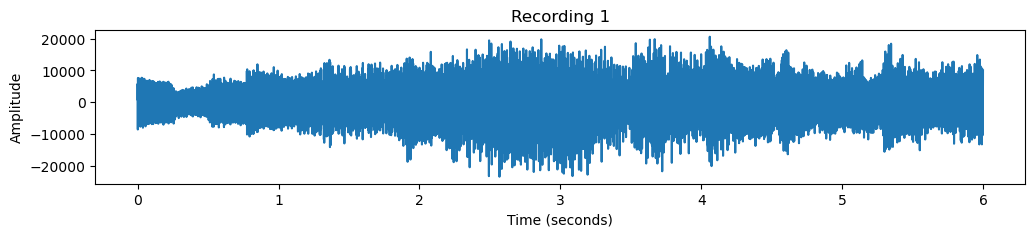

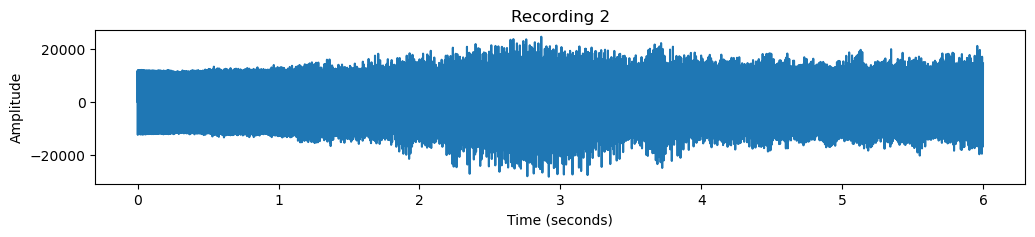

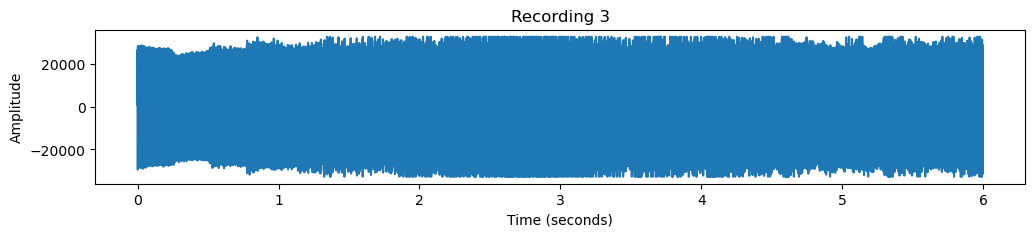

In [6]:
# Function to plot the waveform of a signal
def plot_wave(timing, signal, title):
    plt.figure(figsize=(12, 2))
    plt.title(title)
    plt.plot(timing, signal)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

# Plot the waveforms of the mixed signals
plot_wave(timing_1, signal_1, 'Recording 1')
plot_wave(timing_2, signal_2, "Recording 2")
plot_wave(timing_3, signal_3, 'Recording 3')


### 6. Perform Independent Component Analysis (ICA)

Next, we apply Independent Component Analysis (ICA) using FastICA from sklearn.decomposition. ICA helps separate the mixed audio signals into independent components. We combine the three audio signals into a list of tuples and then apply the ICA transformation to extract the independent components.

After performing ICA, we extract each of the independent components and plot them. These components represent the separated audio sources.



In [7]:
# Combine the signals from all recordings into a list of tuples
# This merges the audio samples element-wise across all three signals
data = list(zip(signal_1, signal_2, signal_3))

# Display a small portion of the combined data for debugging purposes
print("First 10 combined samples:", data[:10])

# Initialize the FastICA algorithm with 3 components (since we have 3 signals)
fastica = FastICA(n_components=3)

# Apply ICA to the mixed signals to separate the independent components
ica_result = fastica.fit_transform(data)

# Display the shape of the ICA result
print("ICA Result Shape:", ica_result.shape)


First 10 combined samples: [(879, 157, 879), (1268, 899, 2584), (1460, 1610, 4081), (1756, 2325, 5682), (1943, 3022, 7147), (2216, 3718, 8689), (2407, 4386, 10114), (2668, 5056, 11583), (2866, 5690, 12954), (3106, 6318, 14327)]
ICA Result Shape: (264515, 3)


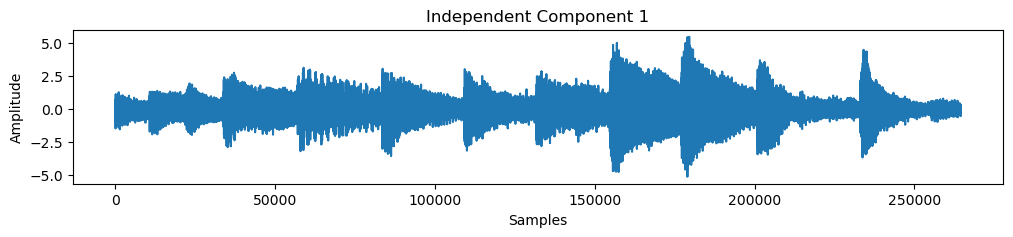

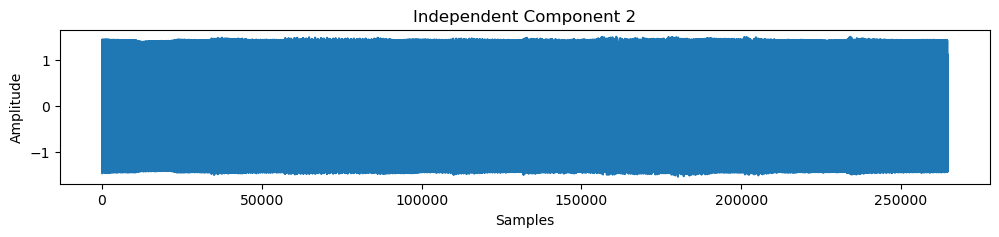

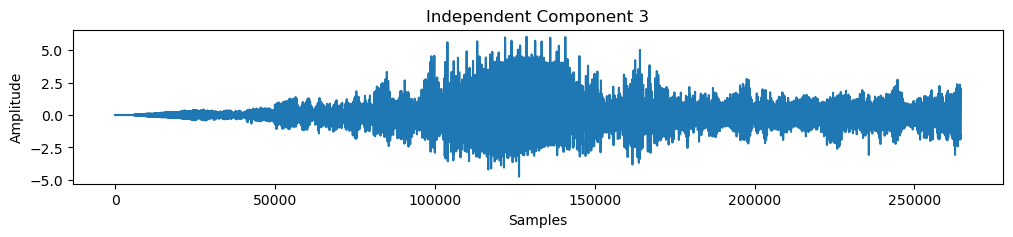

In [8]:
# Extract individual components from the ICA result
result_signal_1 = ica_result[:, 0]
result_signal_2 = ica_result[:, 1]
result_signal_3 = ica_result[:, 2]

# Function to plot the ICA result signals
def plot_result_signal(result_signal, title):
    plt.figure(figsize=(12, 2))
    plt.title(title)
    plt.plot(result_signal)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

# Plot each of the independent components
plot_result_signal(result_signal_1, "Independent Component 1")
plot_result_signal(result_signal_2, "Independent Component 2")
plot_result_signal(result_signal_3, "Independent Component 3")


### 7. Convert the separated signals back to WAV format

We now take the separated signals and convert them back into WAV format. The convert_to_int16() function normalizes and scales the independent components to fit within the 16-bit audio range (-32767 to 32767) and saves the result as a .wav file.

In [9]:
# Function to convert the result signal to int16 format and save as WAV
def convert_to_int16(result_signal, fs, filename):
    # Normalize the signal to a range suitable for 16-bit audio (-32767 to 32767)
    max_val = np.max(np.abs(result_signal))
    normalized_signal = result_signal / max_val if max_val != 0 else result_signal

    # Scale to the int16 range
    scaled_signal = np.int16(normalized_signal * 32767)

    # Save the signal as a WAV file
    wavfile.write(filename, fs, scaled_signal)

# Get the frame rate from the original files
fs_1 = mix_wave_1.getframerate()
fs_2 = mix_wave_2.getframerate()
fs_3 = mix_wave_3.getframerate()

# Convert the separated signals back into WAV format
convert_to_int16(result_signal_1, fs_1, "result_wav_1.wav")
convert_to_int16(result_signal_2, fs_2, "result_wav_2.wav")
convert_to_int16(result_signal_3, fs_3, "result_wav_3.wav")


In [11]:
print("Playing Independent Component 1:")
play_audio("result_wav_1.wav")

Playing Independent Component 1:


In [13]:
print("Playing Independent Component 2:")
play_audio("result_wav_2.wav")

Playing Independent Component 2:


In [12]:
print("Playing Independent Component 1:")
play_audio("result_wav_3.wav")

Playing Independent Component 1:


### Conclusion

In this project, we successfully implemented a solution to the Cocktail Party Problem using Independent Component Analysis (ICA). The Cocktail Party Problem refers to the challenge of separating individual voices or sound sources from a mixture of overlapping signals, similar to how you might focus on a single conversation in a noisy room filled with multiple speakers.